- My own practice to implement(or copy) re-usable/probable codes from scratch. 

In [1]:
import gzip, pickle, pathlib, torch

In [2]:
data_path = pathlib.Path("/content/mnist.pkl.gz")

In [3]:
def get_data(data_path):
    with gzip.open(data_path) as f:
        (x_train, y_train), (x_valid, y_valid), (x_test, y_test)= pickle.load(f, encoding='latin-1')
        return map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))

In [6]:
x_train, y_train, x_valid, y_valid, x_test, y_test = get_data(data_path)

In [7]:
def print_size(): [print(i) for i in map(lambda x: print(x.shape), (x_train, y_train, x_valid, y_valid, x_test, y_test))]
print_size()

torch.Size([50000, 784])
None
torch.Size([50000])
None
torch.Size([10000, 784])
None
torch.Size([10000])
None
torch.Size([10000, 784])
None
torch.Size([10000])
None


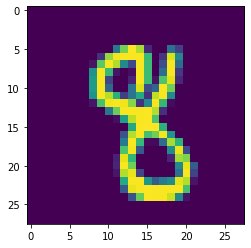

In [19]:
import matplotlib.pyplot as plt
plt.imshow(x_train[-1].view(28, -1))

`Learner`

In [ ]:
# !git clone https://github.com/fastai/course-v3
# !cat course-v3/nbs/dl2/exp/nb_01.py
# !cat course-v3/nbs/dl2/exp/nb_02.py
# !cat course-v3/nbs/dl2/exp/nb_03.py
# !cat course-v3/nbs/dl2/exp/nb_04.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/01_matmul.ipynb

from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)
#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/02_fully_connected.ipynb

from exp.nb_01 import *

def get_data():
   

In [50]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
    
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1

    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break

        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

from functools import partial
from torch.functional import F
from torch import nn, optim, tensor

In [32]:
#A0
x_train, y_train, x_valid, y_valid, x_test, y_test = get_data(data_path)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c=c)

In [40]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [41]:
learn = create_learner(get_model, loss_func, data)

In [45]:
run = Runner(
     [
      AvgStatsCallback([accuracy])
     ]
    )

In [51]:
run.fit(epochs = 3, learn = learn)

train: [0.668972578125, tensor(0.8036)]
valid: [0.337932373046875, tensor(0.9007)]
train: [0.30240625, tensor(0.9132)]
valid: [0.23879384765625, tensor(0.9299)]
train: [0.23860115234375, tensor(0.9312)]
valid: [0.2073470458984375, tensor(0.9413)]


---

In [58]:
learn.opt.param_groups.__len__()

1

In [63]:
get_model

<function __main__.get_model>

In [61]:
for param in learn.opt.param_groups:
    print(param['lr'])

0.5


In [66]:
import inspect
for k,v in inspect.signature(get_model).parameters.items():
    print(k, v)

data data
lr lr=0.5
nh nh=50


In [ ]:
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []

    def after_batch(self):
        """when it's training phase, record learning rate & loss"""
        if not self.in_train: return
        self.lrs.append(self.opt.params_group[-1]['lr'])